In [1]:
# Test deepPET cargando imágenes cargadas directamente con matlab (ficheros mat)
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import tensorflow as tf
import pandas.util.testing as tm
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

/home/nrufo/anaconda3/envs/DeepPET/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


Num GPUs Available:  1


'/device:GPU:0'

In [2]:
import time
import numpy as np
import astra

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse

from Rec_methods import REC_EM,Rec_FBP,REC_EM_REG

import scipy.io as sio

In [18]:
# Load sinogrmas to predict and ground truth

import scipy.io as sio

path=path='/home/nrufo/Final_final//Data_original/set1/Test_data/'



Y_test=np.load(path+'TestImages.npy')
X_test=np.load(path+'TestSinograms.npy')

xsize= X_test.shape[1]
ysize= X_test.shape[2]
nIm= X_test.shape[0]

# Add noise to sinograms
noiseFactor=160
X_test= X_test*noiseFactor
X_test = np.random.poisson(X_test)
# DeepPET reconstruction



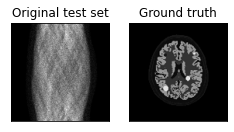

In [21]:
import matplotlib.pyplot as plt
imgID=425



Image = np.squeeze(np.squeeze(X_test[imgID,:,:]))
sinogram= np.squeeze(np.squeeze(Y_test[imgID,:,:]))

plt.subplot(131), plt.imshow(sinogram, cmap='gray')
plt.title('Sinogram), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(Image, cmap='gray')
plt.title('Ground truth'), plt.xticks([]), plt.yticks([])


plt.show()


In [ ]:
#for next methods

import astra
import numpy as np

xsize= X_test.shape[1]
xsize= X_test.shape[2]
vol_geom = astra.create_vol_geom(xsize,xsize)
angles = np.linspace(0, np.pi, xsize, endpoint=False)
proj_geom = astra.create_proj_geom('parallel', 1., xsize, angles)
proj_id = astra.create_projector('linear', proj_geom, vol_geom)

W = astra.OpTomo(proj_id)

In [ ]:
# FPB Reconstruction
nIm=X_test.shape[0]
recIm_FPB= np.zeros((nIm,xsize,ysize))
n=0

tic1 = time.time()

proj_id = astra.create_projector('linear', proj_geom, vol_geom)
while n<nIm:
    
    sinogram= np.squeeze(X_test[n,:,:])
    rec= Rec_FBP(sinogram,proj_id,vol_geom,proj_geom)
    recIm_FPB[n,:,:]= rec
    n+=1

toc1 = time.time()
Time_FPB= toc1 - tic1
print('FBP reconstruction in ',Time_FPB,'s' )


In [ ]:
# STUDY WHICH IS THE BEST ITERATION FOR ITERATIVE METHODS

nIm=30
Image=np.squeeze(Y_test[nIm,:,:])
sinogram=np.squeeze(X_test[nIm,:,:])

tries=60
start=20
m=start
errors=np.zeros(tries-m)
cont=0
beta=0.2
while m<tries:
    iteration=m
    rec= REC_EM_REG(sinogram,proj_id,beta,iteration) #choose which one to study
    #rec= REC_EM(sinogram,proj_id,iteration)
    ssim_E= ssim(Image,rec)
    errors[cont]=ssim_E
    m+=1
    cont+=1

x=errors.max()
n=0
while n<errors.size:
    if errors[n]==x:
        print(n)
        opt=n
    n+=1

print('The best iteration number is '+str(opt-1+start)+' with a SSIM: '+str(errors[opt]))
     

In [ ]:

# EM ReconstructioN

nIm= X_test.shape[0]
recIm_EM= np.zeros((nIm,xsize,ysize))
n=0

iteration=22
projector_id = astra.create_projector('linear', proj_geom, vol_geom)

tic1 = time.time()
while n<nIm:
    sinogram= np.squeeze(X_test[n,:,:])
    rec= REC_EM(sinogram,projector_id,iteration)
    recIm_EM[n,:,:]= rec
    n+=1

toc1 = time.time()
Time_EM= toc1 - tic1
print('EM reconstruction in ',Time_EM,'s' )


In [ ]:
# EMR Reconstruction
nIm=X_test.shape[0]
recIm_EMR= np.zeros((nIm,xsize,ysize))
n=0

iteration=45
beta=0.1 #regularization term
projector_id = astra.create_projector('linear', proj_geom, vol_geom)

tic1 = time.time()
while n<nIm:
    sinogram= np.squeeze(X_test[n,:,:])
    rec= REC_EM_REG(sinogram,projector_id,beta,iteration)
    recIm_EMR[n,:,:]= rec
    n+=1

toc1 = time.time()
Time_EMR= toc1 - tic1
print('EMR reconstruction in ',Time_EMR,'s' )



In [22]:
# DeepPET reconstruction

from tensorflow.keras.models import load_model

path='/home/nrufo/Final_final/DeepPET/'
#path='/home/nrufo/Final/Train_model/Models/'
fileModel=path+'buenisimo.h5' 
model= load_model(fileModel) 

tic1 = time.time()
recIm_DeepPET= model.predict(X_test)
toc1 = time.time()
Time_DeepPET= toc1 - tic1
print('DeepPET reconstruction in ',Time_DeepPET,'s' )


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
DeepPET reconstruction in  0.8561577796936035 s


In [23]:
#AVOID NEGATIVE RESULTS IN DEEPPET

n=0
nIm=recIm_DeepPET.shape[0]
rec_Deepm=np.zeros((nIm,128,128,1))
while n<nIm:
    x=0  
    rec_Deep=np.squeeze(recIm_DeepPET[n,:,:])
    while x<xsize:# to avoid false zeros
      
        y=0
        while y<ysize:
            if  rec_Deep[x,y] <0:
                rec_Deep[x,y]=0
            recIm_DeepPET[n,:,:,0]= rec_Deep
            y+=1
        x+=1
    n+=1


In [ ]:
#SAVE RECONSTRUCTED IMAGES

path='/home/nrufo/Final/Comparison/ImagesReconstructed/7SET/'
np.save(path+'fbp.npy',recIm_FPB)
np.save(path+'EM.npy',recIm_EM)
np.save(path+'EMR.npy',recIm_EMR)

In [24]:
# LOAD YOUR RECONSTRUCTED IMAGES

path='/home/nrufo/Final/Comparison/ImagesReconstructed/7SET/'
recIm_FPB= np.load(path+'fbp.npy')
recIm_EM= np.load(path+'EM.npy')
recIm_EMR=np.load(path+'EMR.npy')

/home/nrufo/anaconda3/envs/DeepPET/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
/home/nrufo/anaconda3/envs/DeepPET/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


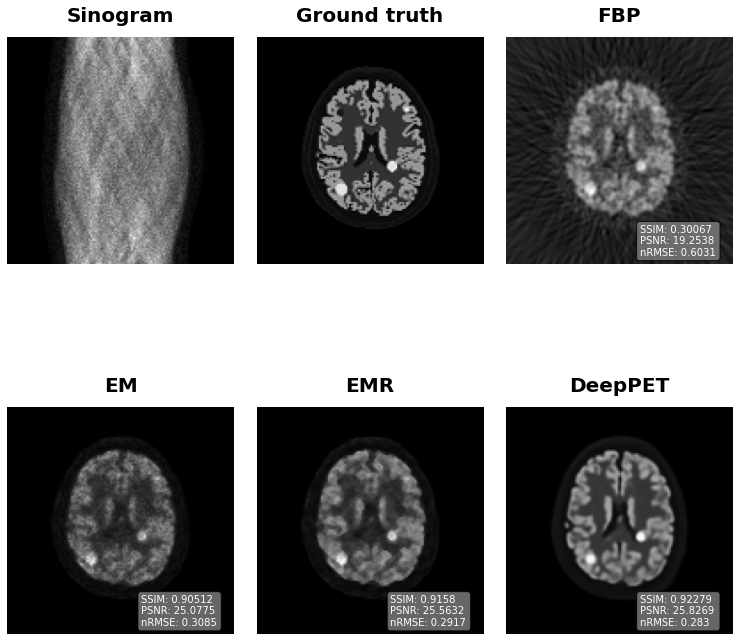

In [25]:
# Calculate error with ground truth

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as nrmse
from skimage.util import img_as_float

nIm=425


Image=Image = np.squeeze(np.squeeze(Y_test[nIm,:,:]))
sinogram=np.squeeze(X_test[nIm,:,:])

#NORMALIZE
rec_fpb=recIm_FPB[nIm,:,:]
rec_EM=recIm_EM[nIm,:,:]
rec_EMR=recIm_EMR[nIm,:,:]
rec_Deep=np.squeeze(recIm_DeepPET[nIm,:,:])

sum1=np.sum(np.sum(Image))

sum2=np.sum(np.sum(rec_EM))
sum3=np.sum(np.sum(rec_fpb))
sum4=np.sum(np.sum(rec_EMR))
sum5=np.sum(np.sum(rec_Deep))

rec_EM= rec_EM*(sum1/sum2)
rec_EMR= rec_EMR*(sum1/sum4)
rec_fpb= rec_fpb*(sum1/sum3)
rec_Deep= rec_Deep*(sum1/sum5)


ssim_FBP=ssim(Image,rec_fpb)
ssim_EM= ssim(Image,rec_EM)
ssim_EMR=ssim(Image,rec_EMR)
ssim_Deep=ssim(Image,rec_Deep)

psnr_FBP=psnr(Image,rec_fpb)
psnr_EM= psnr(Image,rec_EM)
psnr_EMR=psnr(Image,rec_EMR)
psnr_Deep=psnr(Image,rec_Deep)


nrmse_FBP=nrmse(Image,rec_fpb)
nrmse_EM= nrmse(Image,rec_EM)
nrmse_EMR=nrmse(Image,rec_EMR)
nrmse_Deep=nrmse(Image,rec_Deep)


#print(ssim_EMR)
#print(ssim_EM)
#print(ssim_FBP)
# PLOT RESULTS


import matplotlib.pyplot as plt

box_style=dict(boxstyle='round', facecolor='grey', alpha=0.8)

text_FPB='SSIM: '+str(round(ssim_FBP,5))+' \nPSNR: '+str(round(psnr_FBP,4))+' \nnRMSE: '+str(round(nrmse_FBP,4))
text_EM='SSIM: '+str(round(ssim_EM,5))+' \nPSNR: '+str(round(psnr_EM,4))+' \nnRMSE: '+str(round(nrmse_EM,4))
text_EMR='SSIM: '+str(round(ssim_EMR,5))+' \nPSNR: '+str(round(psnr_EMR,4))+' \nnRMSE: '+str(round(nrmse_EMR,4))
text_Deep='SSIM: '+str(round(ssim_Deep,5))+' \nPSNR: '+str(round(psnr_Deep,4))+' \nnRMSE: '+str(round(nrmse_Deep,4))



fig, ax = plt.subplots(2,3,figsize=(13,13))
ax[0,0].imshow(sinogram,cmap='gray'),ax[0,0].set_title('Sinogram',fontsize=20,fontweight ="bold",pad=15), ax[0,0].axis('off')
ax[0,1].imshow(Image, cmap='gray'),ax[0,1].set_title('Ground truth',fontsize=20,fontweight ="bold",pad=15), ax[0,1].axis('off')
ax[0,2].imshow(rec_fpb, cmap='gray'),ax[0,2].set_title('FBP',fontsize=20,fontweight ="bold",pad=15), ax[0,2].axis('off'),ax[0,2].text(75,123,text_FPB,color='white',bbox =box_style)

ax[1,0].imshow(rec_EM,cmap='gray'),ax[1,0].set_title('EM',fontsize=20,fontweight ="bold",pad=15), ax[1,0].axis('off'),ax[1,0].text(75,123,text_EM,color='white',bbox =box_style)
ax[1,1].imshow(rec_EMR, cmap='gray'),ax[1,1].set_title('EMR',fontsize=20,fontweight ="bold",pad=15),  ax[1,1].axis('off'),ax[1,1].text(75,123,text_EMR,color='white',bbox =box_style)
ax[1,2].imshow(rec_Deep, cmap='gray'),ax[1,2].set_title('DeepPET',fontsize=20,fontweight ="bold",pad=15), ax[1,2].axis('off'),ax[1,2].text( 75,123,text_Deep,color='white',bbox =box_style)




plt.subplots_adjust( hspace=0.1,wspace=0.1)
#plt.savefig("/home/nrufo/Final_final_final/transicion2_buenisimo.png",dpi=400)
plt.show()

In [ ]:
# ANALYSE AND EVALUATE QUALITY METRICS

from reportResults import average_error
average_error(Y_test, recIm_FPB, recIm_EM, recIm_EMR, recIm_DeepPET)